<a href="https://colab.research.google.com/github/Aryan-IIT/es335-fall-24-assignment4/blob/main/question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPLANATION OF THIS TASK

In this question you will implement and compare the following different KNN variants:

1.   Naive KNN
2.   LSH
3.   KD-Tree

Vary dataset size $N$, number of dimensions $d$ to do training and testing time and memory comparison for finding $K$ nearest neighbours.

Now, in a 2D randomly generated dataset visually show how many of the $K$ closest neighbors approximate KNN methods miss out on due to their approximate nature.

Also show the partitions in the 2D space.


Procedure: We created multiple datasets with varying values of $N$, the number of data points, and $d$, the number of dimensions. We then split this generated data into train and test data. The test data points were input as queries to each of the three methods and the computational time and memory usage for each algorithm were calculated and compared.

# IMPORTING RELEVANT LIBRARIES AND CREATING DATASETS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # to get sharper graphics
import math
import time
from tabulate import tabulate
from itertools import product

In [ ]:
datasets = {} # creating a dictionary to store different datasets
N_vals = [100, 1000, 10000, 100000] # varying the values of number of datapoints
d_vals = [2, 4, 8, 16] # varying values of number of dimensions
for N in N_vals: # N is the number of points in the dataset
  for d in d_vals: # d is the number of dimensions
    datasets[(N, d)] = np.random.randn(N, d) # key is the tuple (N, d) and value is the dataset

In [ ]:
queries = {key: np.random.randn(10, key[1]) for key in datasets.keys()}

# NAIVE KNN

In [ ]:
def Naive_KNN(d_train,d_test,k):
  times=[]
  d_nn={}
  for i in range(len(d_test)):
    t1=time.time()
    pt_dist={}
    test_pt=d_test[i]
    train=d_train
    dists=np.linalg.norm(train-test_pt,axis=1)
    sorted_dists = np.argsort(dists)[:k] # To get the indices of k shortest distances.
    for j in range(k):
      idx=sorted_dists[j]
      pt_dist[dists[idx]]=d_train[idx]
    d_nn[tuple(test_pt)]=pt_dist
    t2=time.time()
    times.append(t2-t1)
  return d_nn,times

In [ ]:
def print_knn_tables(d_nn):
    for test_pt, neighbors in d_nn.items():
        # Prepare data for tabulation
        table_data = []

        for i, (dist, coords) in enumerate(sorted(neighbors.items()), start=1):
            table_data.append([f"Neighbor {i}", f"{dist:.4f}", np.array2string(coords, formatter={'float_kind': lambda x: f"{x:.4f}"})])

        # Display the test point information
        test_pt_str = np.array2string(np.array(test_pt), formatter={'float_kind': lambda x: f'{x:.4f}'})
        print(f"\nTest Point: {test_pt_str}")

        # Use tabulate to print the table
        print(tabulate(
            table_data,
            headers=["Nearest Neighbor", "Distance", "Coordinates"],
            tablefmt="fancy_grid",
            stralign="center",
            numalign="center"
        ))


In [ ]:
p_test=np.array([0,0])
dict_nn=Naive_KNN(d,3,d[0])



In [ ]:
print_table(dict_nn)


+------------------+------------------+----------+
| Nearest Neighbor |   Coordinates    | Distance |
+------------------+------------------+----------+
|    Neighbor 1    | [0.4967 -0.1383] |  0.0000  |
|    Neighbor 2    | [0.4732 -0.0728] |  0.0695  |
|    Neighbor 3    | [0.2576 -0.0744] |  0.2475  |
+------------------+------------------+----------+


# LSH

In [ ]:
def create_random_hyperplanes(d, L):
  hyperplanes = [] # empty list to store hyperplanes
  for l in range(L): # creating L random hyperplanes with d dimensions
      hp = np.random.randn(1, d+1) # d weights and 1 bias numpy array (1, d+1)
      hyperplanes.append(hp) # added to list
  hyperplanes = np.vstack(hyperplanes) # np array (L, d+1)
  return hyperplanes

def label_data_points(X, hyperplanes):
  X_aug = np.hstack([X, np.ones((X.shape[0], 1))]) # augmented X, added 1 to each row, np array (N, d+1)
  region_mat_ = X_aug @ hyperplanes.T + 1e-6 # region matrix for each point (N, L), hyperplanes was (L, d+1), transpose is (d+1, L)
  region_mat = np.sign(region_mat_)
  y = [] # creating an empty array for the region labels
  tuple_combinations = product([1, -1], repeat=hyperplanes.shape[0])
  labels = {tup: idx for idx, tup in enumerate(tuple_combinations)} # dictionary to store the regions as tuples of sign combinations with labels
  for row in region_mat: # each row is an np array (1, L)
    combination = tuple(row.tolist()) # finding the sign combination of that point
    y.append(labels[combination]) # labelling the point wth region
  y = np.array(y) # 1D numpy array (N,)
  return y, labels

def LSH_find_region(hp, query): # hp (L, d+1), queries (q, d) where q is the number of queries
  query = query.reshape(1, -1) # query (1, d)
  query_aug = np.hstack([query, np.ones((query.shape[0], 1))]) # augmented query matrix (1, d+1)
  region_mat = np.sign(query_aug @ hp.T) # hp.T (d+1, L), query_aug (1, d+1), (1, L)
  region = tuple(region_mat[0]) # tuple of length L, combination for region
  return region

def distances_from_hyperplanes(hyperplanes, query):
  a = hyperplanes[:, :-1]  # normal vectors (L, d)
  b = hyperplanes[:, -1]   # biases (L,)
  query = query.flatten()
  dot_products = np.dot(a, query) + b  # a @ query + b (L,)
  norms = np.linalg.norm(a, axis=1)  # norms of each normal vector a (L,)
  distances = np.abs(dot_products) / norms  # (L,)
  distances = np.argsort(distances) # sort the distances in ascending order
  return distances

def LSH(X, query_list, L, k): # X np array (N, d), query_list list of q (d,) np arrays
  N = X.shape[0]
  d = X.shape[1]
  q = len(query_list)
  hp = create_random_hyperplanes(d, L) # (L, d+1)
  y, labels = label_data_points(X, hp) # y numpy array (N,)
  query_regions = [] # list of len q
  for query in query_list:
    region = LSH_find_region(hp, query)
    query_regions.append(labels[region])
  knn_list = []
  for i in range(q):
    query = query_list[i]
    region_neighbours = []
    for j in range(N):
      if y[j] == query_regions[i]: # points which have the same label as query
        region_neighbours.append(j)
    if len(region_neighbours)<k:
      count = len(region_neighbours)
      poss_regions = []
      curr = LSH_find_region(hp, query)
      dist_from_hp = distances_from_hyperplanes(hp, query)
      hp_index = 0
      while count<k:
        new_region = list(curr)
        index_to_change = dist_from_hp[hp_index]
        if new_region[index_to_change]==1:
          new_region[index_to_change] = -1
        else:
          new_region[index_to_change] = 1
        for p in range(N):
          if y[p] == labels[tuple(new_region)]: # points which have the same label as query
            region_neighbours.append(p)
        count = len(region_neighbours)
        hp_index+=1
        if hp_index==L:
          break
      if count<k:
        dist = {} # point:dist
        for nbr_index in range(N):
          nbr = X[nbr_index] # np array (d,)
          dist[nbr_index] = np.linalg.norm(nbr - query) # float distance
        knn_tuples = sorted(dist.items(), key=lambda x: x[1])[:k] # sort based on distance
        knn = []
        for tup in knn_tuples:
          knn.append(tup[0]) # add indices of nearest neighbours to knn
        knn_list.append(knn)
      return y, labels, hp, query_regions, knn_list
    dist = {} # point:dist
    for nbr_index in region_neighbours:
      nbr = X[nbr_index] # np array (d,)
      dist[nbr_index] = np.linalg.norm(nbr - query) # float distance
    knn_tuples = sorted(dist.items(), key=lambda x: x[1])[:k] # sort based on distance
    knn = []
    for tup in knn_tuples:
      knn.append(tup[0]) # add indices of nearest neighbours to knn
    knn_list.append(knn)
  return y, labels, hp, query_regions, knn_list

In [ ]:
hyperplanes = {}
for N in N_vals: # N points
    for d in d_vals: # d dimensions
        hyperplanes[(N, d)] = create_random_hyperplanes(d, 10)

# MEASURING COMPUTATIONAL TIME AND SPACE USAGE

In [ ]:
for N in N_vals:
  for d in d_vals:
    X = datasets[(N, d)]
    y, labels = label_data_points(X, hyperplanes[(N, d)])
    queries = np.random.randn(10, d) # generating 10 random queries of d dimensions
    begin =
    knn = LSH_NN(X, y, queries, 3)


SyntaxError: invalid syntax (<ipython-input-7-04d3427f50ae>, line 6)

# KD-TREE

# COMPARING METHODS

In [ ]:
# query_point = X[np.random.randint(0, N)]
# def compare_methods(query_point):


# VISUALIZATION OF THE RESULTS FROM DIFFERENT METHODS

In [ ]:
np.random.seed(51)
X_2d = np.random.randint(0, 16, (30, 2)) # creating a 2D dataset
query_point = np.random.randint(0, 16, (1, 2)) # choosing a random query point
k_2d = 4 # number of nearest neighbours

## NAIVE KNN

In [ ]:
nknn =

In [ ]:
plt.figure(figsize = (8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s = 50)
#plt.scatter(X_2d[nknn, 0], X_2d[nknn, 1], c='pink', edgecolor='palevioletred', s=50, label='k-NN') # k nearest neighbours
plt.scatter(query_point[0], query_point[1], c='mediumturquoise', edgecolor='lightseagreen', s=50, label='Query Point') # query point
plt.title("Naive KNN")
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5) # gridlines
plt.show()

## LSH

In [ ]:
def plot_train_query_knn(X, y, query, knn, title, hp_2d):
  plt.figure(figsize=(8, 6))
  x_vals = np.linspace(-1, 16, 100)
  for w1, w2, b in hp_2d:
    if w2 != 0:  # to avoid division by zero
      slope = -w1 / w2
      intercept = -b / w2
      y_vals = slope * x_vals + intercept
      plt.plot(x_vals, y_vals, color='cyan', linestyle='--', linewidth=1, alpha = 0.6)  # hyperplane
    else:  # for vertical lines (w2 == 0)
      if w1 != 0:
        x_val = -b / w1
        plt.axvline(x=x_val, color='cyan', linestyle='--', linewidth=1, alpha = 0.6)  # hyperplane
  plt.xlim(0, 16)
  plt.ylim(0, 16)
  plt.title(title)
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5) # gridlines
  scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50) # training points
  plt.scatter(X[knn, 0], X[knn, 1], c='pink', edgecolor='palevioletred', s=50, label='k-NN') # k nearest neighbours
  plt.scatter(query[0], query[1], c='mediumturquoise', edgecolor='lightseagreen', s=50, label='Query Point') # query point
  plt.colorbar(scatter, label='Continuous Labels')
  plt.legend()
  plt.show()

In [ ]:
L_2d = 4 # number of hyperplanes
y_2d, labels_2d, hp_2d, query_regions_2d, knn_list_2d = LSH(X_2d, [query_point], L_2d, k_2d)

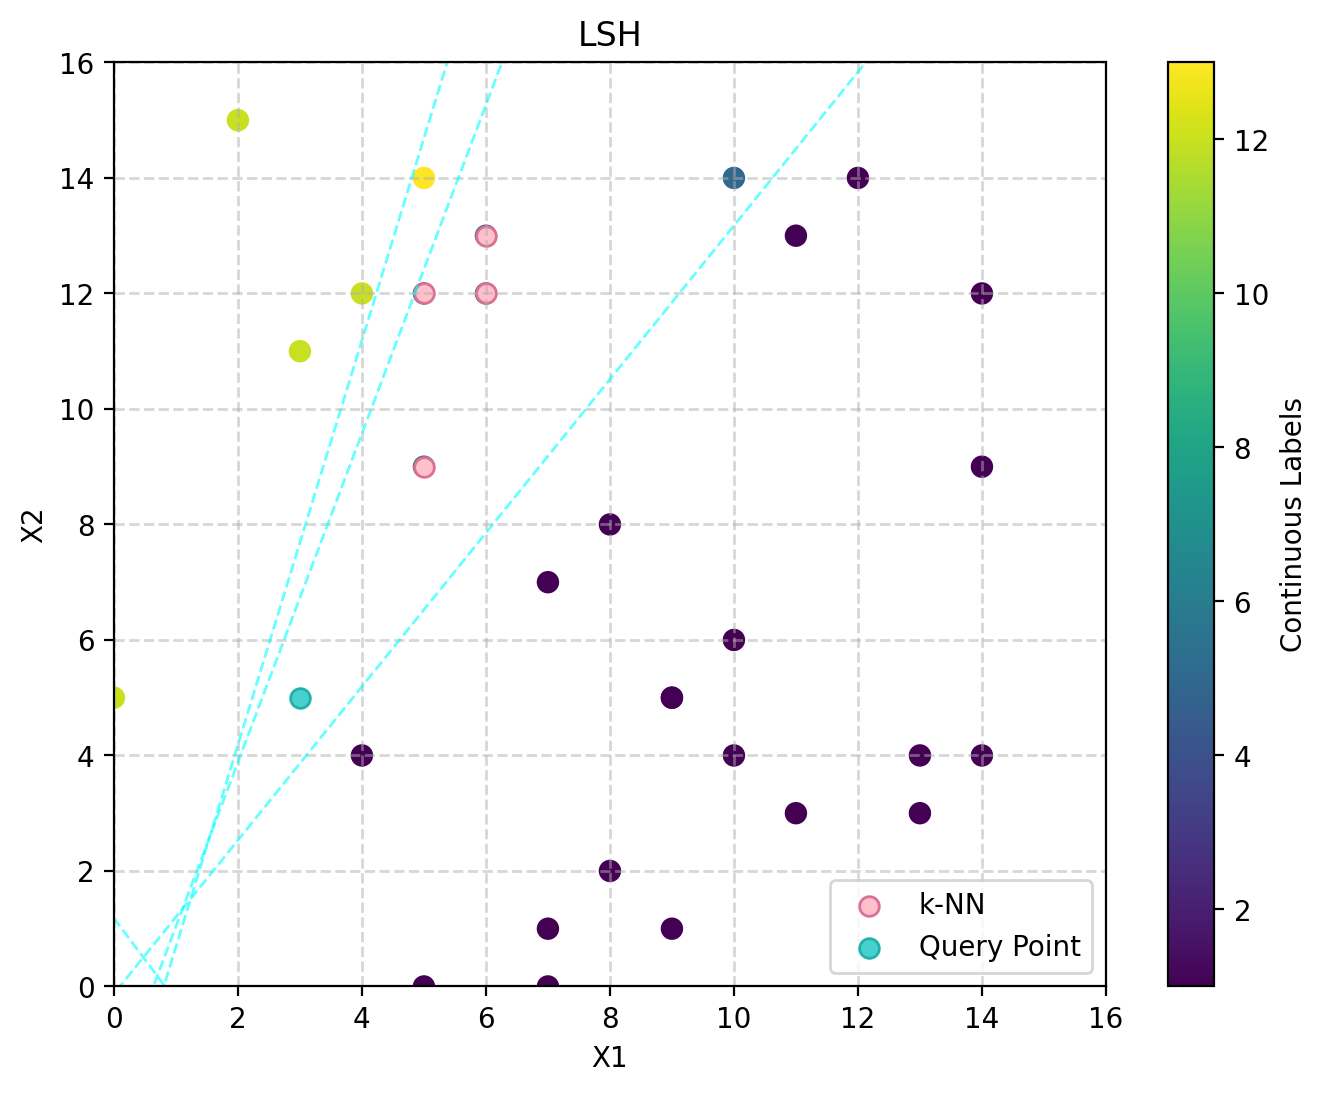

In [ ]:
plot_train_query_knn(X_2d, y_2d, query_point[0], knn_list_2d[0], "LSH", hp_2d)

## KD - TREES